In [ ]:
from IPython.display import display
import ipywidgets as widgets
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib

# 1. Load and prepare the dataset
from google.colab import files
uploaded = files.upload()

Saving weatherHistory.csv to weatherHistory.csv


In [ ]:
df = pd.read_csv('weatherHistory.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 39 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Temperature (C)                              96453 non-null  float64
 1   Apparent Temperature (C)                     96453 non-null  float64
 2   Humidity                                     96453 non-null  float64
 3   Wind Speed (km/h)                            96453 non-null  float64
 4   Wind Bearing (degrees)                       96453 non-null  float64
 5   Visibility (km)                              96453 non-null  float64
 6   Pressure (millibars)                         96453 non-null  float64
 7   Year                                         96453 non-null  int32  
 8   Month                                        96453 non-null  int32  
 9   Day                                          96453 non-null  int32  
 10

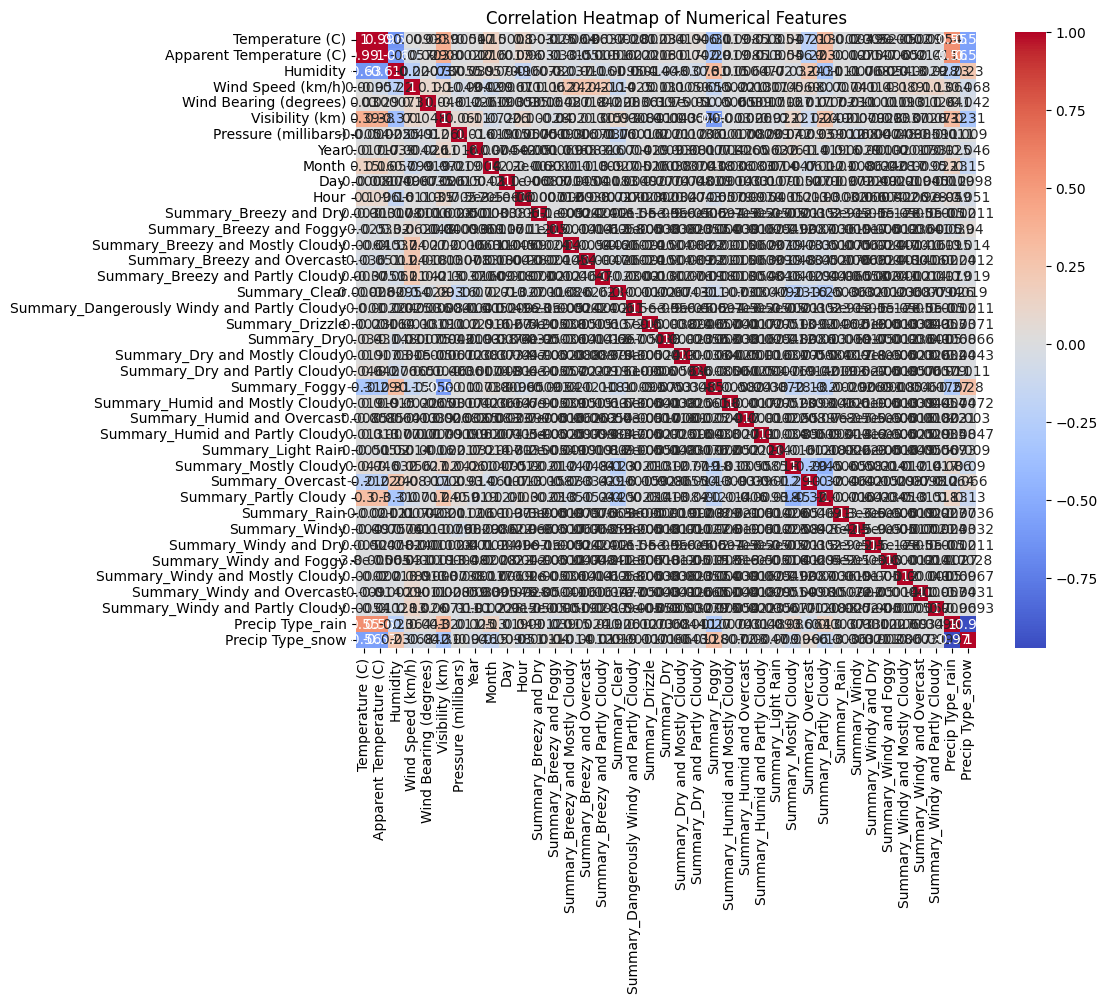

In [ ]:
# 🔍 Exploratory Data Analysis (EDA)

import seaborn as sns
import matplotlib.pyplot as plt

# Check structure and missing values
print(df.info())
print(df.describe())
print(df.isnull().sum())

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

# (Optional) Temperature trend over time
if 'Formatted Date' in df.columns:
    df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], utc=True)
    df = df.sort_values('Formatted Date')
    plt.figure(figsize=(12, 5))
    plt.plot(df['Formatted Date'], df['Temperature (C)'], label='Temperature (C)', color='orange')
    plt.title('Temperature Trend Over Time')
    plt.xlabel('Date')
    plt.ylabel('Temperature (C)')
    plt.grid(True)
    plt.legend()
    plt.show()


In [ ]:
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], utc=True)
df['Year'] = df['Formatted Date'].dt.year
df['Month'] = df['Formatted Date'].dt.month
df['Day'] = df['Formatted Date'].dt.day
df['Hour'] = df['Formatted Date'].dt.hour

# Drop unnecessary columns
df = df.drop(['Formatted Date', 'Loud Cover', 'Daily Summary'], axis=1)

# Handle missing values
df['Precip Type'].fillna('None', inplace=True)

# Convert categorical variables
df = pd.get_dummies(df, columns=['Summary', 'Precip Type'], drop_first=True)

# Prepare features and target
X = df.drop('Temperature (C)', axis=1)
y = df['Temperature (C)']

<ipython-input-3-3058859138>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Precip Type'].fillna('None', inplace=True)


In [ ]:
 #2. Train the model properly
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the LASSO model
model = Lasso(alpha=0.1, random_state=42)
model.fit(X_train_scaled, y_train)

# Get feature names
feature_columns = list(X.columns)

In [ ]:
# 3. Define prediction function
def predict_weather(input_data, model, scaler, feature_columns):
    """Make temperature predictions from input dictionary"""
    # Convert to DataFrame
    df = pd.DataFrame([input_data])

    # Preprocess
    df['Formatted Date'] = pd.to_datetime(df['date'])
    df['Year'] = df['Formatted Date'].dt.year
    df['Month'] = df['Formatted Date'].dt.month
    df['Day'] = df['Formatted Date'].dt.day
    df['Hour'] = df['Formatted Date'].dt.hour

    # Rename columns
    df = df.rename(columns={
        'humidity': 'Humidity',
        'wind_speed': 'Wind Speed (km/h)',
        'pressure': 'Pressure (millibars)',
        'apparent_temp': 'Apparent Temperature (C)',
        'summary': 'Summary',
        'precip_type': 'Precip Type'
    })

    # Handle categoricals
    df = pd.get_dummies(df)

    # Ensure all expected columns exist
    for col in feature_columns:
        if col not in df.columns:
            df[col] = 0

    # Scale and predict
    scaled_data = scaler.transform(df[feature_columns])
    return model.predict(scaled_data)[0]

In [ ]:
# 4. Create the interactive widget
date_input = widgets.Text(value='2023-07-15 14:00:00', description='Date:')
humidity_input = widgets.FloatSlider(value=0.65, min=0, max=1, step=0.01, description='Humidity:')
wind_speed_input = widgets.FloatSlider(value=12.5, min=0, max=100, step=0.1, description='Wind (km/h):')
pressure_input = widgets.FloatSlider(value=1012, min=900, max=1100, step=0.1, description='Pressure (mb):')
apparent_temp_input = widgets.FloatSlider(value=25, min=-20, max=50, step=0.1, description='Apparent Temp (°C):')
summary_input = widgets.Dropdown(options=['Clear', 'Partly Cloudy', 'Cloudy', 'Rainy'], description='Summary:')
precip_input = widgets.Dropdown(options=['None', 'Rain', 'Snow'], description='Precip Type:')

predict_button = widgets.Button(description="Predict Temperature")
output = widgets.Output()

def on_button_click(b):
    input_data = {
        'date': date_input.value,
        'humidity': humidity_input.value,
        'wind_speed': wind_speed_input.value,
        'pressure': pressure_input.value,
        'apparent_temp': apparent_temp_input.value,
        'summary': summary_input.value,
        'precip_type': precip_input.value
    }
    with output:
        output.clear_output()
        prediction = predict_weather(input_data, model, scaler, feature_columns)
        print(f"🌡️ Predicted Temperature: {prediction:.1f}°C")

predict_button.on_click(on_button_click)

display(widgets.VBox([
    date_input,
    humidity_input,
    wind_speed_input,
    pressure_input,
    apparent_temp_input,
    summary_input,
    precip_input,
    predict_button,
    output
]))

In [ ]:
# 5. Build and evaluate LASSO model
lasso = Lasso(alpha=0.1, random_state=42)
lasso.fit(X_train_scaled, y_train)

Lasso(alpha=0.1, random_state=42)

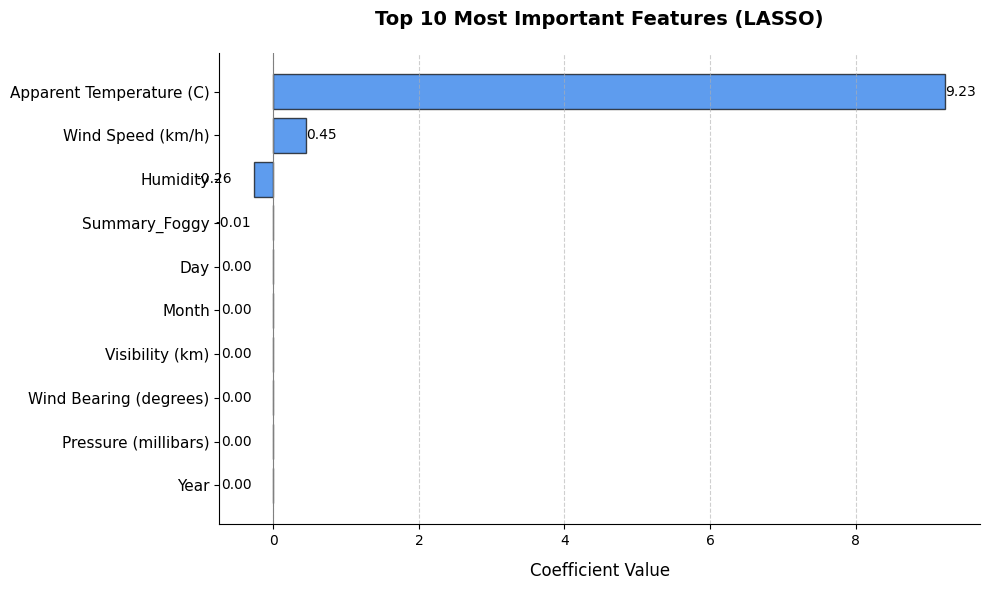

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming you have these variables from your model:
# X.columns (feature names)
# lasso.coef_ (coefficient values)

# Create feature importance DataFrame
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

# Select top 10 features
top_features = feature_importance.head(10).sort_values('Coefficient', key=abs)

# Create the plot with improved styling
plt.figure(figsize=(10, 6))
bars = plt.barh(top_features['Feature'], top_features['Coefficient'],
                color='#1a73e8', alpha=0.7, edgecolor='black')

# Add value labels on each bar
for bar in bars:
    width = bar.get_width()
    label_x = width if width > 0 else width - 0.3  # Adjust label position for negative values
    plt.text(label_x, bar.get_y() + bar.get_height()/2,
             f'{width:.2f}',
             va='center', ha='left' if width > 0 else 'right',
             fontsize=10)

# Customize the plot appearance
plt.title('Top 10 Most Important Features (LASSO)',
          fontsize=14, pad=20, fontweight='bold')
plt.xlabel('Coefficient Value', fontsize=12, labelpad=10)
plt.ylabel('')  # Remove y-axis label
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Make sure y-axis labels match your screenshot
plt.yticks(fontsize=11)

# Add a vertical line at x=0
plt.axvline(x=0, color='gray', linestyle='-', linewidth=0.8)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Make predictions
y_train_pred = lasso.predict(X_train_scaled)
y_test_pred = lasso.predict(X_test_scaled)

# Calculate metrics
metrics = {
    'Train': {
        'MAE': mean_absolute_error(y_train, y_train_pred),
        'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'R2': r2_score(y_train, y_train_pred)
    },
    'Test': {
        'MAE': mean_absolute_error(y_test, y_test_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'R2': r2_score(y_test, y_test_pred)
    }
}

# Display metrics
pd.DataFrame(metrics).round(3)

,Train,Test
MAE,0.746,0.745
RMSE,0.962,0.960
R2,0.990,0.990


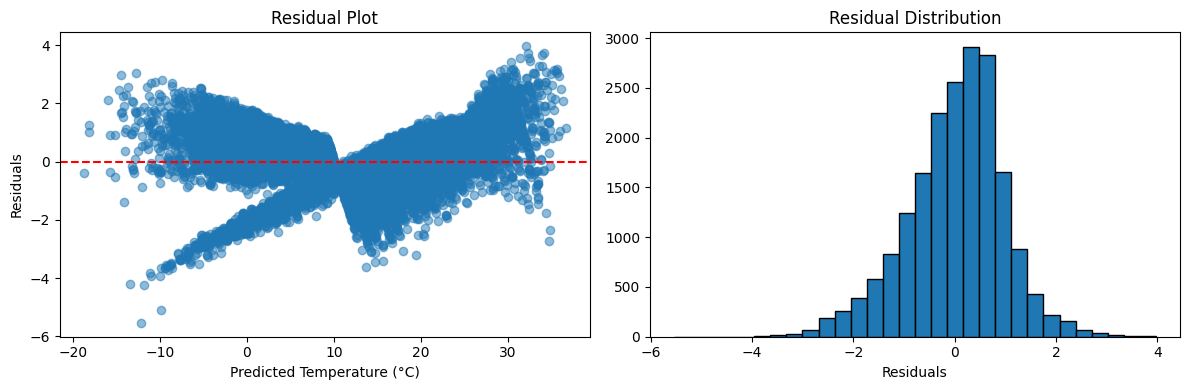

In [ ]:
import matplotlib.pyplot as plt

residuals = y_test - y_test_pred

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Temperature (°C)')
plt.ylabel('Residuals')
plt.title('Residual Plot')

plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30, edgecolor='k')
plt.xlabel('Residuals')
plt.title('Residual Distribution')
plt.tight_layout()
plt.show()

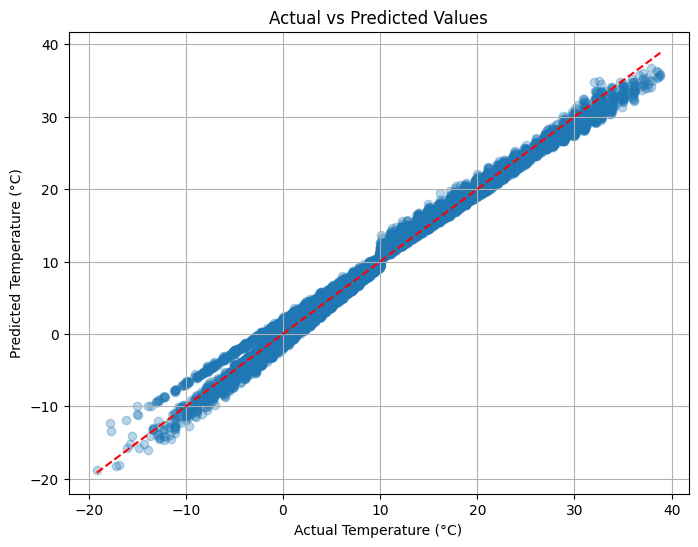

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.3)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Temperature (°C)')
plt.ylabel('Predicted Temperature (°C)')
plt.title('Actual vs Predicted Values')
plt.grid(True)

In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(lasso, X_train_scaled, y_train,
                          cv=5, scoring='neg_mean_squared_error')

print(f"Cross-Validation RMSE: {np.sqrt(-cv_scores).mean():.3f} ± {np.sqrt(-cv_scores).std():.3f}")

Cross-Validation RMSE: 0.962 ± 0.006


In [ ]:
coeff_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print(coeff_df.head(10))

                     Feature  Coefficient
0   Apparent Temperature (C)     9.232532
2          Wind Speed (km/h)     0.449470
1                   Humidity    -0.264397
21             Summary_Foggy    -0.007815
4            Visibility (km)     0.000000
3     Wind Bearing (degrees)    -0.000000
5       Pressure (millibars)    -0.000000
6                       Year     0.000000
8                        Day    -0.000000
7                      Month     0.000000


Text(0.5, 1.0, 'Learning Curve')

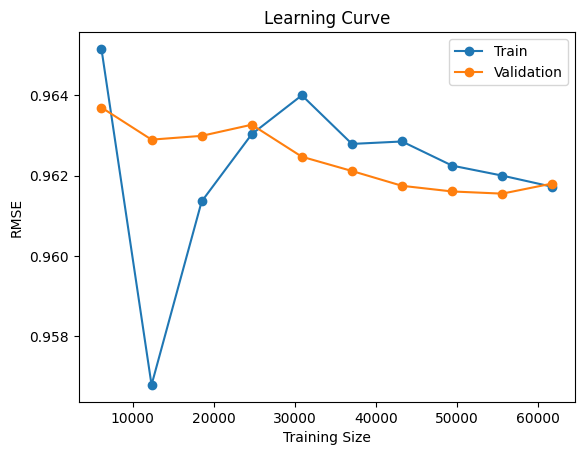

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    lasso, X_train_scaled, y_train, cv=5,
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10))

plt.plot(train_sizes, np.sqrt(-train_scores.mean(axis=1)), 'o-', label='Train')
plt.plot(train_sizes, np.sqrt(-test_scores.mean(axis=1)), 'o-', label='Validation')
plt.xlabel('Training Size')
plt.ylabel('RMSE')
plt.legend()
plt.title('Learning Curve')

In [ ]:
# 4. Create the interactive widget
date_input = widgets.Text(value='2023-07-15 14:00:00', description='Date:')
humidity_input = widgets.FloatSlider(value=0.65, min=0, max=1, step=0.01, description='Humidity:')
wind_speed_input = widgets.FloatSlider(value=12.5, min=0, max=100, step=0.1, description='Wind (km/h):')
pressure_input = widgets.FloatSlider(value=1012, min=900, max=1100, step=0.1, description='Pressure (mb):')
apparent_temp_input = widgets.FloatSlider(value=25, min=-20, max=50, step=0.1, description='Apparent Temp (°C):')
summary_input = widgets.Dropdown(options=['Clear', 'Partly Cloudy', 'Cloudy', 'Rainy'], description='Summary:')
precip_input = widgets.Dropdown(options=['None', 'Rain', 'Snow'], description='Precip Type:')

predict_button = widgets.Button(description="Predict Temperature")
output = widgets.Output()

def on_button_click(b):
    input_data = {
        'date': date_input.value,
        'humidity': humidity_input.value,
        'wind_speed': wind_speed_input.value,
        'pressure': pressure_input.value,
        'apparent_temp': apparent_temp_input.value,
        'summary': summary_input.value,
        'precip_type': precip_input.value
    }
    with output:
        output.clear_output()
        prediction = predict_weather(input_data, model, scaler, feature_columns)
        print(f"🌡️ Predicted Temperature: {prediction:.1f}°C")

predict_button.on_click(on_button_click)

display(widgets.VBox([
    date_input,
    humidity_input,
    wind_speed_input,
    pressure_input,
    apparent_temp_input,
    summary_input,
    precip_input,
    predict_button,
    output
]))

In [ ]:
# Prepare features and target
X = df.drop('Temperature (C)', axis=1)
y = df['Temperature (C)']

# 🔽 ADD THIS RIGHT HERE 🔽

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features (for Lasso)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)




In [ ]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

# Train Lasso model
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train)

# Predict on test data
y_pred_lasso = lasso.predict(X_test_scaled)

# Evaluate the model
print("🔎 Lasso Regression Performance:")
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred_lasso))
print("R² Score:", r2_score(y_test, y_pred_lasso))


🔎 Lasso Regression Performance:
Mean Squared Error (MSE): 0.9218926454007899
R² Score: 0.989996745919883


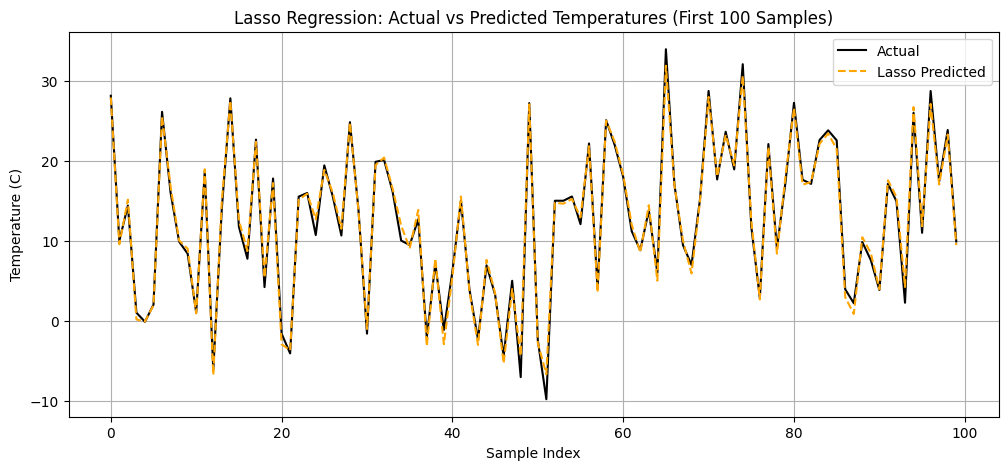

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(y_test.values[:100], label='Actual', color='black')
plt.plot(y_pred_lasso[:100], label='Lasso Predicted', linestyle='--', color='orange')
plt.title('Lasso Regression: Actual vs Predicted Temperatures (First 100 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Temperature (C)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)  # No need for scaling
y_pred_rf = rf.predict(X_test)

print("🌳 Random Forest Performance:")
print("MSE:", mean_squared_error(y_test, y_pred_rf))
print("R² Score:", r2_score(y_test, y_pred_rf))


🌳 Random Forest Performance:
MSE: 0.0021439133394578576
R² Score: 0.9999767368684767


In [ ]:
import pandas as pd

results = {
    'Model': ['Lasso Regression', 'Random Forest'],
    'MSE': [0.9219, 0.0021],
    'R² Score': [0.99, 0.99997]
}

results_df = pd.DataFrame(results)
print(results_df)


              Model     MSE  R² Score
0  Lasso Regression  0.9219   0.99000
1     Random Forest  0.0021   0.99997


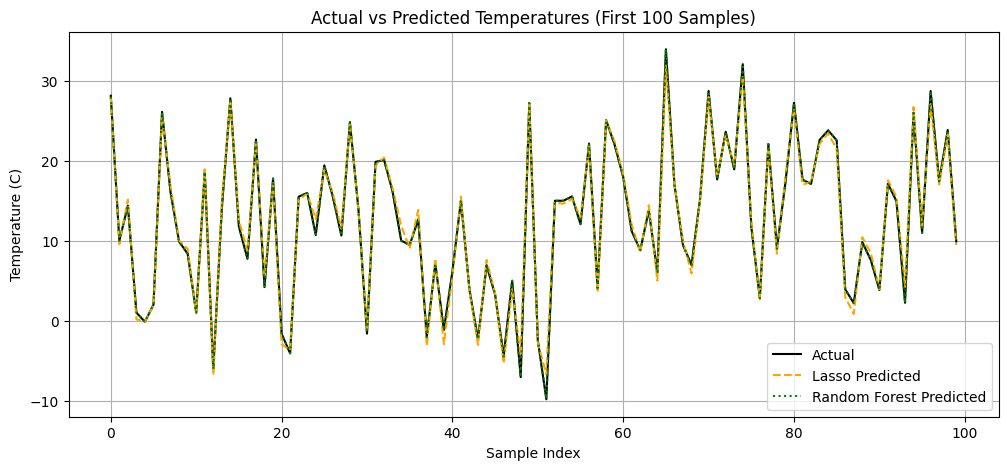

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(y_test.values[:100], label='Actual', color='black')
plt.plot(y_pred_lasso[:100], label='Lasso Predicted', linestyle='--', color='orange')
plt.plot(y_pred_rf[:100], label='Random Forest Predicted', linestyle=':', color='green')
plt.title('Actual vs Predicted Temperatures (First 100 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Temperature (C)')
plt.legend()
plt.grid(True)
plt.show()


In [31]:
import joblib

joblib.dump(model, "lasso_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(feature_columns, "feature_columns.pkl")


['feature_columns.pkl']

In [32]:
from google.colab import files

files.download("lasso_model.pkl")
files.download("scaler.pkl")
files.download("feature_columns.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>